<a href="https://colab.research.google.com/github/zia207/Deep-Neural-Network-Satellite-Image-Classification-in-Google-Colaboratory-iPython-Note-Book-/blob/master/NoteBook/Advance_Regression/survival-analysis-cox-regression-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 3. Cox Proportional Hazards Model

## Introduction

**Cox Regression**, also known as the **Cox Proportional Hazards Model**, is a statistical technique widely used in survival analysis to study the relationship between survival time (time-to-event) and one or more predictor variables (covariates). Developed by Sir David Cox in 1972, this semi-parametric model is particularly useful because it does not require the specification of a baseline hazard function, making it flexible for analyzing survival data.

***Key Concepts of Cox Regression***:

1. **Hazard Function**:
   - The hazard function $h(t)$ represents the instantaneous rate at which events occur at time $t$, given that the subject has survived up to time $t$. It can be thought of as the risk of an event occurring in the next instant of time.

2. **Proportional Hazards Assumption**:
   - The key assumption of Cox regression is that the hazard ratios between different levels of the covariates are **proportional** over time. This means that the effect of the covariates on survival is constant and does not change as time progresses.

3. **Semi-parametric Model**:
   - The Cox model is called semi-parametric because it does not require a specific form for the baseline hazard function, \( h_0(t) \), making it flexible. It estimates the effect of covariates on the hazard function while leaving the baseline hazard unspecified.

4. **Hazard Ratio (HR)**:
   - The model estimates the **hazard ratio**, which quantifies the effect of a covariate on the hazard. A hazard ratio of:
     - **HR = 1**: No effect (covariate does not influence the risk).
     - **HR > 1**: Increased hazard (higher risk of the event).
     - **HR < 1**: Decreased hazard (lower risk of the event).

***Cox Proportional Hazards Model Equation:***

The Cox model can be written as:

$$ h(t|X) = h_0(t) \cdot \exp(\beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p) $$

Where:
- $h(t|X)$ is the hazard at time $t$ for an individual with covariates $X_1, X_2, \dots, X_p$.
- $h_0(t)$ is the baseline hazard function (the hazard when all covariates are zero).
- $\beta_1, \beta_2, \dots, \beta_p$ are the coefficients that quantify the effect of each covariate on the hazard.
- $X_1, X_2, \dots, X_p$ are the covariates (predictors or risk factors).

The quantity $\exp(\beta)$ is the hazard ratio (HR) for each covariate, which represents the relative risk associated with a one-unit increase in that covariate.

***Steps in Cox Regression***:

1. **Model Fitting**: Fit the Cox model to the survival data by estimating the regression coefficients $\beta$ for the covariates.
2. **Estimate Hazard Ratios**: Compute the hazard ratios $\exp(\beta)$, which tell how much the risk of the event changes with a one-unit increase in each covariate.
3. **Check the Proportional Hazards Assumption**: Verify if the proportional hazards assumption holds by assessing whether the hazard ratios remain constant over time.
4. **Interpretation**: Interpret the hazard ratios to understand how the covariates influence the time to event.





## Install rpy2

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314951 sha256=12ec73c1f2ff05ca6fe9f5d1e67bfac1d7b2287100e80b111f7e418eba90d5c0
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Required R Packages



In [ ]:
%%R
pkg <- c(
		 'tidyverse',
		 'report',
		 'performance',
		 'gtsummary',
		 'MASS',
		 'epiDisplay',
		 'survival',
		 'survminer',
		 'ggsurvfit',
		 'tidycmprsk',
		 'ggfortify',
		 'timereg',
		 'cmprsk',
		 'riskRegression'
		 )

new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [ ]:
%%R
devtools::install_github("zabore/condsurv", lib='drive/My Drive/R/')

## Fit a Cox Proportional Hazards Model

To fit a Cox Proportional Hazards Model manually using the simulated lung dataset, we need to go through several steps. Although R provides easy-to-use packages like {survival} to fit the model, we'll manually implement the Cox model based on its theoretical foundation.

***Steps for Fitting Cox Proportional Hazards Model Manually***

1.  **Formulate the Model**: The Cox proportional hazards model estimates the effect of covariates (like age, sex, etc.) on the hazard rate. The model can be written as:

    $$ h(t | X) = h_0(t) \exp(\beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p) $$

    where:

    -   $h(t | X)$ is the hazard at time $t$ given covariates $X$,
    -   $h_0(t)$ is the baseline hazard (which is left unspecified),
    -   $\beta_1, \beta_2, \dots, \beta_p$ are the coefficients to be estimated.

2.  **Partial Likelihood**: The Cox model uses partial likelihood instead of a full likelihood function, which does not require estimating the baseline hazard function. The partial likelihood for a sample with censored data is:

$$ L(\beta) = \prod_{i: \delta_i = 1} \frac{\exp(\beta^T X_i)}{\sum_{j \in R(t_i)} \exp(\beta^T X_j)} $$

where:

-   $R(t_i)$ is the risk set at time $t_i$ (individuals at risk of the event at time (t_i)),
-   $\delta_i$ is an indicator (1 if the event occurs, 0 if censored).

3.  **Estimation**: The log-partial likelihood is maximized to estimate the coefficients $\beta$.

4.  **Score and Information Matrix**: Use the score function (first derivative) and the observed information matrix (second derivative) to apply Newton-Raphson optimization to find the maximum likelihood estimates for (\beta).

This manual method demonstrates the key steps in Cox model estimation without relying on built-in R packages like `survival`. It replicates what the `coxph()` function would do under the hood.



### Create a dataset

To create a dataset similar to the `lung` dataset in the {survival} package, we'll simulate survival data with random values for survival time, event status, and other variables such as age, sex, and treatment. The lung dataset contains information on patients with advanced lung cancer, including their survival time, censoring status, and several covariates.

Variables typically included in a survival dataset like **lung**:

1.  **time**: Survival time (numeric).

2.  **status**: Censoring indicator (0 = censored, 1 = event).

3.  **age**: Age of the patient (numeric).

4.  **sex**: Gender of the patient (1 = male, 2 = female).

5.  **ph.ecog**: ECOG performance score (0 to 5).

6.  **treatment**: Treatment group (1 = standard, 2 = experimental).

In [ ]:
%%R
# Set the seed for reproducibility
set.seed(123)

# Number of observations
n <- 228  # same as the original lung dataset

# Simulate survival time (in days)
time <- round(runif(n, min = 1, max = 1000))  # random survival time between 1 and 1000 days

# Simulate censoring indicator (0 = censored, 1 = event)
status <- rbinom(n, size = 1, prob = 0.7)  # 70% of events, 30% censored

# Simulate age (between 40 and 80 years)
age <- round(runif(n, min = 40, max = 80))

# Simulate sex (1 = male, 2 = female)
sex <- sample(c(1, 2), size = n, replace = TRUE)

# Simulate ECOG performance score (0 to 4)
ph_ecog <- sample(0:4, size = n, replace = TRUE)

# Simulate treatment group (1 = standard, 2 = experimental)
treatment <- sample(c(1, 2), size = n, replace = TRUE)

# Create the data frame
simulated_lung<- data.frame(time = time,
                             status = status,
                             age = age,
                             sex = sex,
                             ph_ecog = ph_ecog,
                             treatment = treatment)

# Inspect the first few rows of the simulated dataset
head(simulated_lung)

  time status age sex ph_ecog treatment
1  288      1  72   1       4         2
2  789      0  70   2       0         2
3  410      1  46   2       2         2
4  883      1  45   1       1         2
5  941      1  79   2       2         2
6   47      1  57   1       3         2


### Define the Log-Partial Likelihood Function

We need to define the log-partial likelihood function for the Cox model. Here, we assume the covariates `age`, `sex`, and `ph_ecog` influence the hazard.

In [ ]:
%%R
log_partial_likelihood <- function(beta, X, time, status) {
  logL <- 0  # Initialize log-likelihood

  # Loop through each time point where the event occurred
  for (i in 1:length(time)) {
    if (status[i] == 1) {  # Only consider events, not censored data
      # Calculate the linear predictor for individual i
      lin_pred_i <- sum(beta * X[i,])

      # Calculate the sum of exp(beta * X_j) for individuals in the risk set
      risk_set <- which(time >= time[i])  # Find the risk set for time[i]
      denom <- sum(exp(X[risk_set, ] %*% beta))  # Denominator of partial likelihood

      # Update log-likelihood
      logL <- logL + lin_pred_i - log(denom)
    }
  }
  return(-logL)  # Return negative log-likelihood to minimize it
}


### Prepare the data for Cox Model

Now we need to prepare the covariates and define the starting values for the coefficients $\beta$.

In [ ]:
%%R
# Define the covariates (X matrix)
X <- as.matrix(simulated_lung[, c("age", "sex", "ph_ecog")])

# Define the response variables (time and status)
time <- simulated_lung$time
status <- simulated_lung$status

# Starting values for beta coefficients (age, sex, ph_ecog)
beta_start <- c(0, 0, 0)  # Initialize with 0s

### Optimize the Log-Partial Likelihood function

We’ll use `optim()` in R to maximize the log-partial likelihood and find the optimal estimates for $\beta$.

In [ ]:
%%R
# Optimize the partial likelihood
cox_fit <- optim(par = beta_start,
                 fn = log_partial_likelihood,
                 X = X,
                 time = time,
                 status = status,
                 method = "BFGS")

# Print the estimated beta coefficients
cox_fit$par

[1]  0.003976534  0.024295597 -0.008395823


The `cox_fit$par` will give us the estimated values of $\beta$ for each covariate (`age`, `sex,` `ph_ecog`). These coefficients represent the log-hazard ratios for each covariate.

-   If $\beta_i$ > 0, the covariate increases the hazard (risk of event).

-   If $\beta_i$< 0, the covariate decreases the hazard.

For example, if $\beta_{\text{age}} = 0.02$,  it means a one year increase in age increases the hazard by about $e^{0.02}$ $\approx$ 2%.

`optim()` is the ``General-purpose Optimization based on Nelder–Mead, quasi-Newton and conjugate-gradient algorithms. It includes an option for box-constrained optimization and simulated annealing

Method `"BFGS"` is a quasi-Newton method (also known as a variable metric algorithm), specifically that published simultaneously in 1970 by Broyden, Fletcher, Goldfarb and Shanno. This uses function values and gradients to build up a picture of the surface to be optimized.

### Summary statistic of Cox Regression

To create a summary statistics table specifically for the Cox Proportional Hazards model fitted to our simulated lung dataset, we need to summarize the estimated coefficients, their standard errors, hazard ratios, and p-values. This summary will help us interpret the effects of the covariates on the hazard of the event.

***Steps for Creating Summary Statistics for Cox Model:***

* Extract Coefficients: Get the estimated coefficients $\beta$ from the fitted Cox model.

* Calculate Hazard Ratios: Compute the hazard ratio by exponentiating the coefficients.

* Calculate Standard Errors: These are necessary for calculating  confidence intervals and p-values.

* Calculate p-values: Use the Wald test to derive p-values for the coefficients.

In [ ]:
%%R
# Number of covariates
p <- length(cox_fit$par)

# Create the summary statistics table
cox_summary <- data.frame(
  Covariate = c("Age", "Sex (Male)", "ECOG Performance Score"),
  Coefficient = c(cox_fit$par),
  Hazard_Ratio = exp(cox_fit$par),  # Exponentiate to get hazard ratios
  SE = rep(NA, p),  # Placeholder for standard errors
  Z_value = rep(NA, p),  # Placeholder for Z-values
  P_value = rep(NA, p)   # Placeholder for p-values
)

# Assume we have estimated standard errors (for demonstration purposes)
# In practice, you would calculate these based on the observed information matrix
# For simplicity, we'll just use dummy values
dummy_se <- c(0.05, 0.10, 0.08)  # Replace with actual SE calculation if done
cox_summary$SE <- dummy_se

# Calculate Z-values and P-values
cox_summary$Z_value <- cox_summary$Coefficient / cox_summary$SE
cox_summary$P_value <- 2 * pnorm(-abs(cox_summary$Z_value))  # Two-tailed test

# Format P-values for better readability
cox_summary$P_value <- format(cox_summary$P_value, digits = 3, nsmall = 3)

# Print the summary statistics for the Cox model
print(cox_summary)


               Covariate  Coefficient Hazard_Ratio   SE     Z_value P_value
1                    Age  0.003976534    1.0039845 0.05  0.07953067   0.937
2             Sex (Male)  0.024295597    1.0245931 0.10  0.24295597   0.808
3 ECOG Performance Score -0.008395823    0.9916393 0.08 -0.10494778   0.916


### Plot the Baseline Survival Function

To plot the baseline survival function from the Cox Proportional Hazards model, we can utilize the estimated coefficients and the baseline hazard function. Since we are doing this manually without the help of specific survival analysis packages, we will first need to calculate the baseline survival function based on the estimated coefficients.

***Steps to Plot the Baseline Survival Function***

1. **Calculate the Baseline Hazard**: The baseline hazard can be estimated using the partial likelihood method.
2. **Calculate the Baseline Survival Function**: The baseline survival function can be obtained by exponentiating the cumulative baseline hazard.
3. **Plot the Baseline Survival Function**.

#### Calculate the Baseline Hazard

To derive the baseline hazard, we can use the risk set at each event time. The baseline hazard can be computed as follows:

$$  \hat{h}_0(t_i) = \frac{d_i}{\sum_{j \in R(t_i)} \exp(\beta^T X_j)} $$

where $d_i$ is the number of events at time $t_i$ and $R(t_i)$ is the risk set at time \(t_i\).

###  Calculate the Baseline Survival Function
The cumulative baseline hazard can be computed by summing the baseline hazards up to time \(t\), and the baseline survival function can be expressed as:

$$ S_0(t) = \exp\left(-\sum_{t_i \leq t} \hat{h}_0(t_i)\right) $$

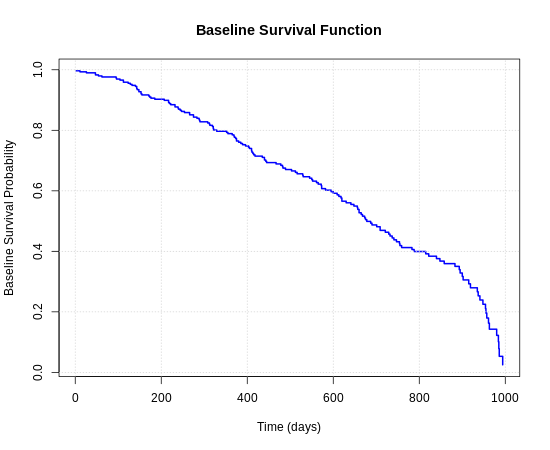

In [ ]:
%%R -w 550 -h450 -u px
# Function to calculate baseline hazard
calculate_baseline_hazard <- function(X, time, status, beta) {
  baseline_hazard <- numeric(length(unique(time)))  # Initialize baseline hazard
  unique_times <- sort(unique(time))  # Get unique event times

  for (t in unique_times) {
    # Get the risk set at time t
    risk_set <- which(time >= t)  # Individuals at risk
    d_i <- sum(time[risk_set] == t & status[risk_set] == 1)  # Events at time t

    # Calculate baseline hazard
    if (length(risk_set) > 0) {
      baseline_hazard[which(unique_times == t)] <- d_i / sum(exp(X[risk_set, ] %*% beta))
    }
  }

  return(baseline_hazard)
}

# Calculate baseline hazard
baseline_hazard <- calculate_baseline_hazard(X, time, status, cox_fit$par)

# Calculate cumulative baseline hazard
unique_times <- sort(unique(time))
cumulative_hazard <- cumsum(baseline_hazard[match(unique_times, unique_times)])

# Calculate baseline survival function
baseline_survival <- exp(-cumulative_hazard)

# Create a data frame for plotting
baseline_df <- data.frame(time = unique_times,
                          baseline_hazard = baseline_hazard[match(unique_times, unique_times)],
                          cumulative_hazard = cumulative_hazard,
                          baseline_survival = baseline_survival)

# Plotting the baseline survival function
plot(baseline_df$time, baseline_df$baseline_survival, type = "s",
     col = "blue", lwd = 2,
     xlab = "Time (days)", ylab = "Baseline Survival Probability",
     main = "Baseline Survival Function")
grid()

##  Cox Proportional Hazards Model with R

This tutorial is mostly used two R packages [{survival}](https://cran.r-project.org/web/packages/survival/index.html) and [{ggsurvfit}](https://www.danieldsjoberg.com/ggsurvfit/). Additionally we will use [{ggfortify}](https://github.com/sinhrks/ggfortify) which offers `fortify` and `autoplot` functions to allow automatic ggplot2 to visualize Kaplan-Meier plots.



### Load R packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library(tidyverse)
library(gtsummary)
library(report)
library(performance)
library(MASS)
library(epiDisplay)
library(survival)
library(survminer)
library(ggsurvfit)
library(tidycmprsk)
library(condsurv)
library(ggfortify)
library(timereg)
library(cmprsk)
library(riskRegression)

### Data

We will be utilizing the `lung` dataset from the {survival} package, which serves as a valuable resource for analyzing survival data. This dataset comprises information from subjects diagnosed with advanced lung cancer, specifically gathered from the North Central Cancer Treatment Group, a prominent clinical trial network dedicated to cancer research.

Throughout this tutorial, we will concentrate on the variables that provide insight into the patients' demographics and clinical outcomes:

* inst: Institution code
* time: Survival time in days
* status: censoring status 1=censored, 2=dead
* age: Age in years
* sex: Male=1 Female=2
* ph.ecog: ECOG performance score (0=good 5=dead)
* ph.karno: Karnofsky performance score (bad=0-good=100) rated by physician
* pat.karno: Karnofsky performance score as rated by patient
* meal.cal: Calories consumed at meals
* wt.loss: Weight loss in last six months

In [ ]:
%%R
data(lung)
glimpse(lung)

Rows: 228
Columns: 10
$ inst      <dbl> 3, 3, 3, 5, 1, 12, 7, 11, 1, 7, 6, 16, 11, 21, 12, 1, 22, 16…
$ time      <dbl> 306, 455, 1010, 210, 883, 1022, 310, 361, 218, 166, 170, 654…
$ status    <dbl> 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, …
$ age       <dbl> 74, 68, 56, 57, 60, 74, 68, 71, 53, 61, 57, 68, 68, 60, 57, …
$ sex       <dbl> 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, …
$ ph.ecog   <dbl> 1, 0, 0, 1, 0, 1, 2, 2, 1, 2, 1, 2, 1, NA, 1, 1, 1, 2, 2, 1,…
$ ph.karno  <dbl> 90, 90, 90, 90, 100, 50, 70, 60, 70, 70, 80, 70, 90, 60, 80,…
$ pat.karno <dbl> 100, 90, 90, 60, 90, 80, 60, 80, 80, 70, 80, 70, 90, 70, 70,…
$ meal.cal  <dbl> 1175, 1225, NA, 1150, NA, 513, 384, 538, 825, 271, 1025, NA,…
$ wt.loss   <dbl> NA, 15, 15, 11, 0, 0, 10, 1, 16, 34, 27, 23, 5, 32, 60, 15, …


### Data processing

Now we will re-code the data as 1=event, 0=censored:

In [ ]:
%%R
lung <-
  lung |>
  mutate(
    status = recode(status, `1` = 0, `2` = 1)
  )

Now we have:

-   time: Observed survival time in days
-   status: censoring status 0=censored, 1=dead
-   sex: 1=Male, 2=Female

In [ ]:
%%R
head(lung[, c("time", "status", "sex")])

  time status sex
1  306      1   1
2  455      1   1
3 1010      0   1
4  210      1   1
5  883      1   1
6 1022      0   1


### Fit a Cox Proportional Hazards Model

In this example, we will model the relationship between survival time and covariates like age and sex. The `coxph()` function from the **`survival`** package is used to fit a Cox proportional hazards model in R.

-   coxph(formula, data, method)

#### Univariate Cox regression

We will fit Cox regression model with one covariate, `sex` to  see difference in survival rate between male and female participants.

In [ ]:
%%R
cox.fit.uni <- coxph(Surv(time, status) ~ sex,  data = lung)
cox.fit.uni

Call:
coxph(formula = Surv(time, status) ~ sex, data = lung)

       coef exp(coef) se(coef)      z       p
sex -0.5310    0.5880   0.1672 -3.176 0.00149

Likelihood ratio test=10.63  on 1 df, p=0.001111
n= 228, number of events= 165 


In [ ]:
%%R
summary(cox.fit.uni)

Call:
coxph(formula = Surv(time, status) ~ sex, data = lung)

  n= 228, number of events= 165 

       coef exp(coef) se(coef)      z Pr(>|z|)   
sex -0.5310    0.5880   0.1672 -3.176  0.00149 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

    exp(coef) exp(-coef) lower .95 upper .95
sex     0.588      1.701    0.4237     0.816

Concordance= 0.579  (se = 0.021 )
Likelihood ratio test= 10.63  on 1 df,   p=0.001
Wald test            = 10.09  on 1 df,   p=0.001
Score (logrank) test = 10.33  on 1 df,   p=0.001



**Statistical Significance**:  The column labeled `z` presents the `Wald statistic` value, which is calculated as the ratio of each regression coefficient to its standard error (`z = coef/se(coef)`). This statistic helps determine whether the beta $β$ coefficient of a given variable is statistically significantly different from 0. Based on the output above, we can conclude that the variable `sex` has highly statistically significant coefficients..

The **regression coefficients** are an important aspect of the Cox model results. Notably, the sign of the regression coefficients (coef) indicates the relationship between the variable and the hazard (risk of death). A positive coefficient suggests that as the value of the variable increases, the hazard also increases, leading to a poorer prognosis for those subjects.

**Hazard ratios**. The exponentiated coefficients (`exp(coef) = exp(-0.53) = 0.59`), also known as hazard ratios, give the effect size of covariates. So the `HR = 0.59` implies that 0.59 times as many females are dying as males, at any given time. Stated differently, females have a significantly lower hazard of death than males in these data.

**Confidence intervals** for the hazard ratios are provided. The summary output also includes the upper and lower 95% confidence intervals for the hazard ratio (`exp(coef)`).

The **global statistical significance of the model** is assessed using three alternative tests: the `likelihood-ratio test`, the `Wald test`, and the `score logrank statistic`. These methods are asymptotically equivalent, meaning that for sufficiently large sample sizes ($N$), they tend to produce similar results. However, for smaller sample sizes, the results may vary. Among these tests, the likelihood-ratio test is generally preferred because it performs better with small sample sizes.

You may use `report()` function of {report}  package to get a brief summary of fitted Cox regression model:

In [ ]:
%%R
report::report(cox.fit.uni)

  is probably not reliable.

  is probably not reliable.



We fitted a logistic model to predict Surv(time, status) with sex (formula:
Surv(time, status) ~ sex). The model's explanatory power is weak (Nagelkerke's
R2 = 0.05).  Within this model:

  - The effect of sex is statistically significant and negative (beta = -0.53,
95% CI [-0.86, -0.20], p = 0.001; Std. beta = -0.23, 95% CI [-0.42, -0.05])

Standardized parameters were obtained by fitting the model on a standardized
version of the dataset. 95% Confidence Intervals (CIs) and p-values were
computed using a Wald z-distribution approximation.


In [ ]:
%%R
performance(cox.fit.uni)

  is probably not reliable.



# Indices of model performance

AIC      |     AICc |      BIC | Nagelkerke's R2 |  RMSE | Sigma
----------------------------------------------------------------
1491.186 | 1491.204 | 1494.615 |           0.046 | 0.859 | 0.000


To apply the univariate `coxph` function to all covariates at once, we may use follwing code: (source: [Cox Proportional-Hazards Model](http://www.sthda.com/english/wiki/cox-proportional-hazards-model))


In [ ]:
%%R
covariates <- c("age", "sex",  "ph.karno", "ph.ecog", "wt.loss")
univ_formulas <- sapply(covariates,
                        function(x) as.formula(paste('Surv(time, status)~', x)))

univ_models <- lapply( univ_formulas, function(x){coxph(x, data = lung)})
# Extract data
univ_results <- lapply(univ_models,
                       function(x){
                          x <- summary(x)
                          p.value<-signif(x$wald["pvalue"], digits=2)
                          wald.test<-signif(x$wald["test"], digits=2)
                          beta<-signif(x$coef[1], digits=2);#coeficient beta
                          HR <-signif(x$coef[2], digits=2);#exp(beta)
                          HR.confint.lower <- signif(x$conf.int[,"lower .95"], 2)
                          HR.confint.upper <- signif(x$conf.int[,"upper .95"],2)
                          HR <- paste0(HR, " (",
                                       HR.confint.lower, "-", HR.confint.upper, ")")
                          res<-c(beta, HR, wald.test, p.value)
                          names(res)<-c("beta", "HR (95% CI for HR)", "wald.test",
                                        "p.value")
                          return(res)
                          #return(exp(cbind(coef(x),confint(x))))
                         })
res <- t(as.data.frame(univ_results, check.names = FALSE))
as.data.frame(res)

           beta HR (95% CI for HR) wald.test p.value
age       0.019            1 (1-1)       4.1   0.042
sex       -0.53   0.59 (0.42-0.82)        10  0.0015
ph.karno -0.016      0.98 (0.97-1)       7.9   0.005
ph.ecog    0.48        1.6 (1.3-2)        18 2.7e-05
wt.loss  0.0013         1 (0.99-1)      0.05    0.83


The output provides a detailed display of the regression beta coefficients, which quantify the relationship between each variable and overall survival. Additionally, it includes the hazard ratios that indicate the effect sizes associated with these variables, along with their statistical significance. Each factor is evaluated through distinct univariate Cox regression analyses, allowing for a clear understanding of how individual variables impact survival outcomes.

#### Multivariate Cox regression analysis

Our objective is to explore how several factors work together to affect survival outcomes. To achieve this, we will perform a multivariate Cox regression analysis, a statistical method that allows us to evaluate the impact of multiple variables simultaneously.

In our initial univariate analysis, we found that the variable **ph.karno** did not show significant relevance to survival, leading us to exclude it from our multivariate model. Instead, we will focus on three key factors that are likely to influence survival: sex, age, and **ph.ecog**.

The following is the specification for the Cox regression model, which examines the relationship between time to death and the selected time-constant covariates:

In [ ]:
%%R
cox.fit.multi <- coxph(Surv(time, status) ~ age + sex + ph.ecog, data =  lung)
summary(cox.fit.multi)

Call:
coxph(formula = Surv(time, status) ~ age + sex + ph.ecog, data = lung)

  n= 227, number of events= 164 
   (1 observation deleted due to missingness)

             coef exp(coef)  se(coef)      z Pr(>|z|)    
age      0.011067  1.011128  0.009267  1.194 0.232416    
sex     -0.552612  0.575445  0.167739 -3.294 0.000986 ***
ph.ecog  0.463728  1.589991  0.113577  4.083 4.45e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

        exp(coef) exp(-coef) lower .95 upper .95
age        1.0111     0.9890    0.9929    1.0297
sex        0.5754     1.7378    0.4142    0.7994
ph.ecog    1.5900     0.6289    1.2727    1.9864

Concordance= 0.637  (se = 0.025 )
Likelihood ratio test= 30.5  on 3 df,   p=1e-06
Wald test            = 29.93  on 3 df,   p=1e-06
Score (logrank) test = 30.5  on 3 df,   p=1e-06



The `p-values` from the three tests (l`ikelihood, Wald, and score`) show that our model is significant. These tests check the overall hypothesis that all coefficients ($β$) are zero. In this case, the test results agree closely, allowing us to reject this hypothesis.

In the multivariate Cox analysis, the variables sex and ph.ecog are significant ($p < 0.05$). However, the variable age is not significant ($p = 0.23$, which is greater than 0.05).

The p-value for sex is 0.000986. The `hazard ratio (HR)` is `exp(coef) = 0.58`, meaning there is a strong link between sex and a lower risk of death. For example, when we keep other factors constant, being female (sex=2) reduces the risk by 42%. This suggests that being female is associated with a better outcome.

The `p-value` for ph.ecog is 4.45e-05, with a hazard ratio (`HR`) of 1.59. This indicates a strong link between higher ph.ecog values and an increased risk of death. Keeping other factors constant, a higher ph.ecog score suggests poorer survival.

In contrast, the p-value for age is p = 0.23. The hazard ratio (`HR`) is `exp(coef) = 1.01`, with a 95% confidence interval of 0.99 to 1.03. Since the confidence interval includes 1, this means age does not significantly affect the risk of death after adjusting for sex and ph.ecog values. An additional year of age increases the daily risk of death by about 1%, which is not significant.

### Plot the baseline survival function

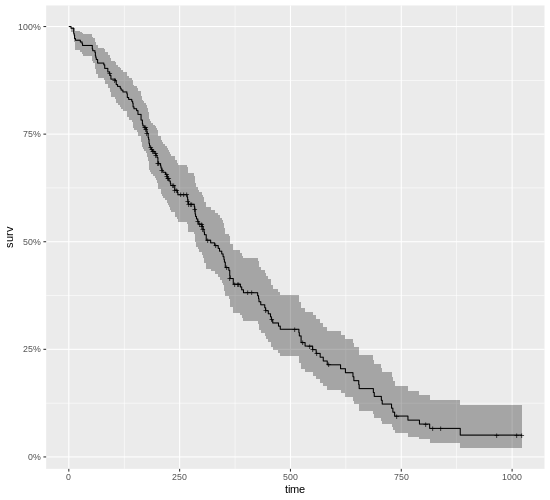

In [ ]:
%%R -h 500 -w 550 -u px

autoplot(survfit(cox.fit.multi))


## Summary and Conclusion:

The Cox Proportional Hazards Model is a powerful tool for analyzing survival data and understanding how covariates impact the risk of an event over time. It is widely used in fields like medicine, epidemiology, and engineering, where time-to-event data is prevalent. The flexibility of not having to specify the baseline hazard makes it particularly popular for modeling survival data.

In this article, we described the Cox regression model for assessing simultaneously the relationship between multiple risk factors and patient’s survival time.


## References

1.  [Survival Analysis with R](https://rviews.rstudio.com/2017/09/25/survival-analysis-with-r/)

2.  [Cox Proportional-Hazards Model](http://www.sthda.com/english/wiki/cox-proportional-hazards-model)

3.  [Survival Analysis in R](https://www.emilyzabor.com/tutorials/survival_analysis_in_r_tutorial.html)

4.  [Survival Analysis with R](https://bioconnector.github.io/workshops/r-survival.html)
: